# SMOTE + Normalization + ML

1. SMOTE &rarr; Oversampling technique (called Synthetic Minority Oversampling Technique)

2. No Feature Engineering applied

# 1. Import Necessary Libraries

In [1]:
# For Computational and random seed purpose
import numpy as np
np.random.seed(42)
# To read csv file
import pandas as pd
# To Split data into train and cv data
from sklearn.model_selection import train_test_split
# To compute AUROC score
# For AUROC Score (Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
from sklearn.metrics import  roc_curve, auc
# Oversampling technique: SMOTE
from imblearn.over_sampling import SMOTE
# Data is umbalance, we need Calibrated Model to ive confidence probabilities result
from sklearn.calibration import CalibratedClassifierCV
# For Hyperparameter and CV Fold
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# For plot AUROC graph
import matplotlib.pyplot as plt
# For heatmap
import seaborn as sns
# To ignore warninga
import warnings
warnings.filterwarnings('ignore')
# To stndardize the data
from sklearn.preprocessing import MinMaxScaler

D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

# 2. Read train data

In [2]:
# Locate parent directory
data_dir = "./"

# Read csv file and display top 5 rows
df_train = pd.read_csv(data_dir+'/train.csv')
df_train.head(5)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [3]:
df_test = pd.read_csv(data_dir+'/test.csv')
df_test.head(5)

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,...,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,...,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,...,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,...,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


# 3. Split and Oversampling data

In [4]:
# Take separate for features value
X = df_train.drop(['id','target'], axis=1)
# Take separate for class value
y = df_train['target'].values
# Take test feature value
ts_X = df_test.drop(['id'], axis=1)
# Split the data into train and cv
tr_X, cv_X, tr_y, cv_y = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
# SMOTE (Ref: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)
smote = SMOTE()
# Oversampling using SMOTE technique
tr_X, tr_y = smote.fit_sample(tr_X, tr_y)

# 4. Normalization

In [5]:
# Fit and transform on train data
stand_vec = MinMaxScaler()
tr_X = stand_vec.fit_transform(tr_X)
pd.DataFrame(tr_X).head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.543185,0.385981,0.307849,0.486355,0.593561,0.548421,0.309127,0.730249,0.761705,0.344966,...,0.533780,0.694508,0.788640,0.198537,0.957192,0.640174,0.456048,0.283599,0.700638,0.688088
1,0.536840,0.360374,0.582875,0.362963,0.454180,0.333629,0.769649,0.242868,0.711077,0.369924,...,0.575939,0.328375,0.217732,0.584535,0.793216,0.474931,0.552811,0.373565,0.372348,0.682507
2,0.429595,0.668411,0.542508,0.541326,0.731114,0.284675,0.213147,0.666423,0.082794,0.230753,...,0.255424,0.507437,0.690333,0.491118,0.707056,0.503144,0.449574,0.383006,0.479899,0.557965
3,0.447605,0.656262,0.623445,0.691033,0.192427,0.596488,0.614632,0.600585,0.251618,0.124365,...,0.473276,0.508581,0.471327,0.417346,0.124977,0.607609,0.468654,0.799889,0.434505,0.337426
4,0.161891,0.607477,0.423038,0.435673,0.394366,0.523413,0.904745,0.400146,0.468786,0.491751,...,0.171812,0.736651,0.179865,0.376594,0.765463,0.710463,0.266780,0.552388,0.473817,0.678042


In [6]:
# Transform on cv data based on mean and std on train data
cv_X = stand_vec.transform(cv_X)
pd.DataFrame(cv_X).head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.307818,0.205421,0.471764,0.318129,0.479056,0.361121,0.647591,0.461960,0.555577,0.377538,...,0.679309,0.428680,0.579829,0.394984,0.286595,0.414154,0.284668,0.681970,0.396084,0.517621
1,0.826852,0.712150,0.203466,0.288109,0.579111,0.466300,0.687613,0.480432,0.245527,0.666244,...,0.841418,0.348207,0.442563,0.704911,0.616724,0.475415,0.696082,0.266753,0.425456,0.538032
2,0.199959,0.533832,0.425688,0.530604,0.643314,0.238560,0.845346,0.520666,1.004949,0.696277,...,0.327747,0.746949,0.579465,0.368443,0.287321,0.778494,0.525554,0.464458,0.295357,0.619678
3,0.029267,0.095514,0.616514,0.330994,0.263947,0.682866,0.593263,0.445318,0.485535,0.665398,...,0.662904,0.436499,0.851265,0.358830,0.739888,0.542157,0.359796,0.350796,0.523661,0.822995
4,0.468072,0.616449,0.920082,0.324951,0.685019,0.062433,0.472836,0.399232,0.474496,0.175127,...,0.397248,0.969489,0.361369,0.505747,0.766008,0.505078,0.490630,0.472233,0.589230,0.328018


In [7]:
# Transform on test data based on mean and std value from train data
ts_X = stand_vec.transform(ts_X)
pd.DataFrame(ts_X).head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.576955,0.354766,0.179817,0.520078,0.338760,0.593650,0.635820,0.455925,0.396079,0.772420,...,0.479097,-0.035278,0.348079,0.891745,0.545982,0.838949,0.552470,0.494632,0.522623,0.714240
1,0.633442,0.718692,0.404281,0.722417,0.310774,0.589748,0.643607,0.422275,0.565474,0.786168,...,0.374140,0.453280,0.506463,0.584117,0.532197,0.312591,-0.085860,0.565902,0.383623,0.436772
2,0.832788,0.642991,0.493374,0.622612,0.382294,0.757893,0.411988,0.112107,0.264560,0.534687,...,0.478038,0.532799,0.391407,0.303448,0.590604,0.608254,0.614991,0.538874,0.279484,0.950885
3,0.360827,0.201121,0.365953,0.572515,0.760563,0.595424,0.281963,0.611558,0.624096,0.619289,...,0.435350,0.315789,0.548334,0.450993,0.444586,0.642915,0.859455,0.708812,0.238837,0.314304
4,0.628940,0.502056,0.744139,0.143470,0.471008,0.570238,0.680369,0.157096,0.254282,0.302665,...,0.879873,0.258009,0.541234,0.705329,0.570288,0.547155,0.437138,0.485006,0.305296,0.689683


# 5. Apply ML Models (with hyperparameter)

In [8]:
def hyperparameter_model(models, params):
    '''
    Hyperparameter tuning with StratifiedKFold follow by GridSearchCV follow by CalibratedClassifier
    
    Parameters:
    models: Instance of the model
    params: list of parameters with value fr tuning (dict)
    
    Return:
    grid_clf: return gridsearch model    
    '''
    # Perform KCrossValidation with stratified target
    str_cv = StratifiedKFold(n_splits=10, random_state=42)
    # Perform Hyperparamter using GridSearchCV
    grid_clf = GridSearchCV(models, params, cv=str_cv, return_train_score=True, scoring='roc_auc')
    # Fit the train model to evaluate score
    grid_clf.fit(tr_X, tr_y)
    return grid_clf

# Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc(try_true, try_pred, cvy_true, cvy_pred, n_classes):
    '''
    Compute ROC curve and ROC area for each class
    
    Parameters:
    try_true: train true label
    try_pred: train predict probabilities value
    cvy_true: cv true label
    cvy_pred: cv predict probabilities value
    n_classes: number of unique classes
    
    Return:
    Plot of ROC Curve for train and cv data    
    '''
    # For train
    tr_fpr = dict()
    tr_tpr = dict()
    tr_roc_auc = dict()
    for i in range(n_classes):
        tr_fpr[i], tr_tpr[i], _ = roc_curve(try_true, try_pred[:, i])
        tr_roc_auc[i] = auc(tr_fpr[i], tr_tpr[i])

    # For cv
    cv_fpr = dict()
    cv_tpr = dict()
    cv_roc_auc = dict()
    for i in range(n_classes):
        cv_fpr[i], cv_tpr[i], _ = roc_curve(cvy_true, cvy_pred[:, i])
        cv_roc_auc[i] = auc(cv_fpr[i], cv_tpr[i])

    # Line thickness
    lw = 2
    # Plot roc for train
    plt.plot(tr_fpr[1], tr_tpr[1], color='red',
            lw=lw, label='ROC curve for Train (area = %0.2f)' % tr_roc_auc[1])
    # Plot roc for cv
    plt.plot(cv_fpr[1], cv_tpr[1], color='green',
            lw=lw, label='ROC curve for CV (area = %0.2f)' % cv_roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: train vs cv')
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_importance(model, model_name, top_n = 10):
    '''
    Plot the feature importance on the basis of model.
    
    Parameters:
    model: Instance of model
    model_name: Name of the model
    top_n: Number of feature you want to print top features
    
    Return:
    df: DataFrame that return feature names with coefficient in descending order
    Plot the feature importance
    '''

    # Numpy Column Stack (See Docs: https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.column_stack.html)

    column_name = df_train.drop(['id','target'], axis=1).columns
    if model_name == 'log_model':
        feat_imp_coef = model.coef_.ravel()
    else:
        feat_imp_coef = model.feature_importances_
    temp = pd.DataFrame(data=np.column_stack((column_name, feat_imp_coef)), columns=['col_name','coef'])
    temp = temp.sort_values(by='coef', ascending=False).reset_index()
    df = temp
    temp = temp[:top_n]
    plt.figure(figsize=(20,5))
    sns.barplot(data=temp, y='coef', x='col_name', order=temp['col_name'])
    plt.grid()
    plt.show()
    return df

# 5.1 kNN

In [13]:
# Import KNN
from sklearn.neighbors import KNeighborsClassifier

In [14]:
# kNN (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

# List of params
params = {'n_neighbors':np.arange(3,51,2).tolist(), 'algorithm': ['kd_tree', 'brute']}
# Instance of knn model
knn_model = KNeighborsClassifier()
# Call hyperparameter for find the best params as possible
knn_clf = hyperparameter_model(knn_model, params)

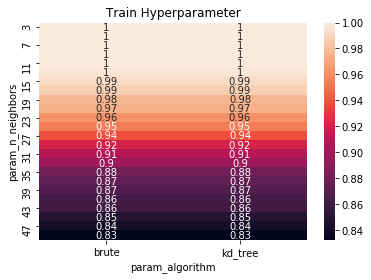

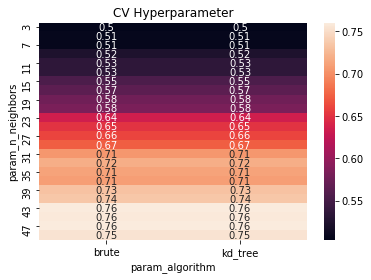

In [15]:
cv_pvt = pd.pivot_table(pd.DataFrame(knn_clf.cv_results_), values='mean_test_score', index='param_n_neighbors', \
                     columns='param_algorithm')
tr_pvt = pd.pivot_table(pd.DataFrame(knn_clf.cv_results_), values='mean_train_score', index='param_n_neighbors', \
                     columns='param_algorithm')

plt.title('Train Hyperparameter')
sns.heatmap(tr_pvt, annot=True)
plt.show()

plt.title('CV Hyperparameter')
sns.heatmap(cv_pvt, annot=True)
plt.show()

In [16]:
print(knn_clf.best_params_)
print('CV Score',knn_clf.score(cv_X,cv_y))

{'algorithm': 'kd_tree', 'n_neighbors': 47}
CV Score 0.75


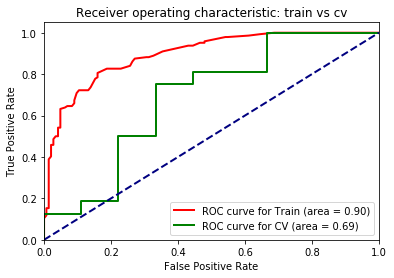

In [17]:
clf = CalibratedClassifierCV(knn_clf, cv=3)
clf.fit(tr_X,tr_y)

tr_pred = clf.predict_proba(tr_X)
cv_pred = clf.predict_proba(cv_X)

# Plot ROC cureve of train and cv data
plot_roc(tr_y, tr_pred, cv_y, cv_pred, 2)

# 5.1.1 Kaggle Score

In [18]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
knn_csv = clf.predict_proba(ts_X)[:,1]
knn_df = pd.DataFrame(np.column_stack((temp_id,knn_csv)), columns=['id','target'])
knn_df['id'] = knn_df['id'].astype('int32')
knn_df.to_csv(data_dir+'/submission_knn.csv', index=False)

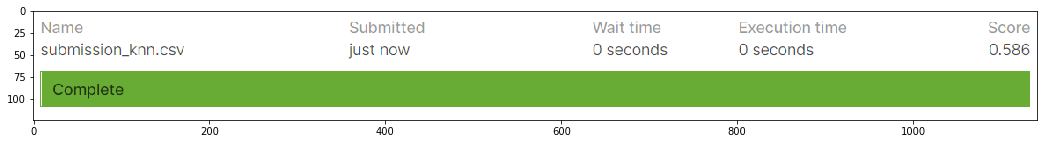

In [19]:
image = plt.imread(data_dir+'/submission_knn.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

## 5.2 Logistic Regression

In [9]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

In [21]:
# LogisticRegression (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

# List of hyperparameter that has to be tuned
params = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[10**i for i in range(-4,5)], 'solver':['liblinear','sag']}
# Instance of logistic regression
log_model = LogisticRegression(random_state=42, class_weight='balanced')
# Call hyperparemeter to find the best params
log_clf = hyperparameter_model(log_model, params)

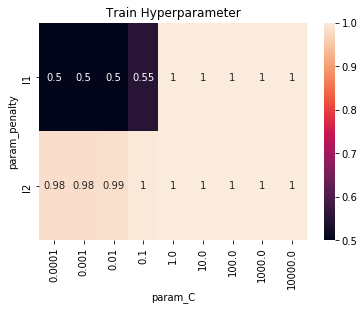

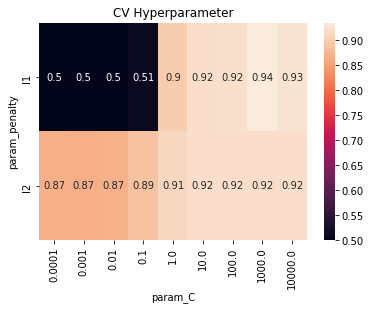

In [22]:
cv_pvt = pd.pivot_table(pd.DataFrame(log_clf.cv_results_), values='mean_test_score', index='param_penalty', \
                     columns='param_C')
tr_pvt = pd.pivot_table(pd.DataFrame(log_clf.cv_results_), values='mean_train_score', index='param_penalty', \
                     columns='param_C')

plt.title('Train Hyperparameter')
sns.heatmap(tr_pvt, annot=True)
plt.show()

plt.title('CV Hyperparameter')
sns.heatmap(cv_pvt, annot=True)
plt.show()

In [23]:
print(log_clf.best_params_)
print('cv score',log_clf.score(cv_X,cv_y))

{'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
cv score 0.701388888888889


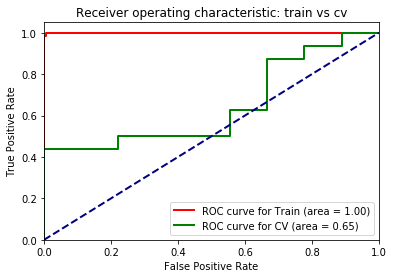

In [24]:
clf = CalibratedClassifierCV(log_clf, cv=3)
clf.fit(tr_X,tr_y)

tr_pred = clf.predict_proba(tr_X)
cv_pred = clf.predict_proba(cv_X)

# Plot ROC cureve of train and cv data
plot_roc(tr_y, tr_pred, cv_y, cv_pred, 2)

In [25]:
log_model = LogisticRegression(**log_clf.best_params_, random_state=42, class_weight='balanced')
log_model.fit(tr_X, tr_y)

LogisticRegression(C=1000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

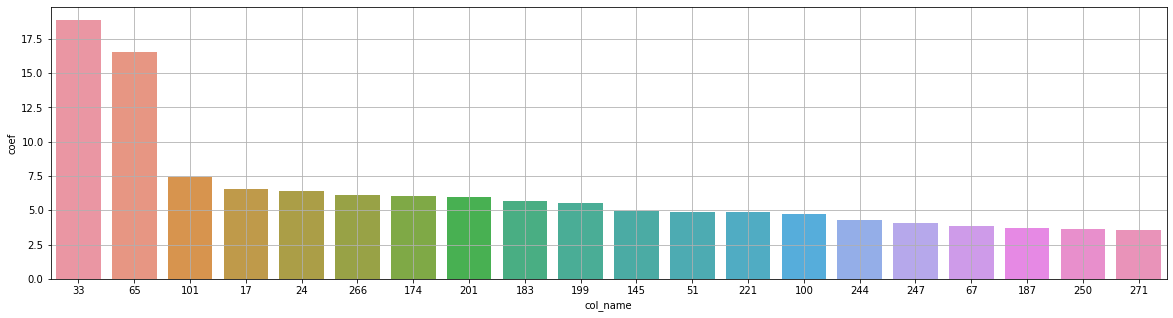

In [26]:
df = plot_feature_importance(log_model, 'log_model', 20)

## 5.2.1 Kaggle Score

In [27]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
log_csv = clf.predict_proba(ts_X)[:,1]
log_df = pd.DataFrame(np.column_stack((temp_id,log_csv)), columns=['id','target'])
log_df['id'] = log_df['id'].astype('int32')
log_df.to_csv(data_dir+'/submission_log.csv', index=False)

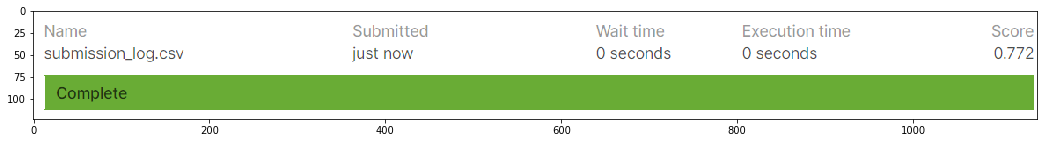

In [28]:
image = plt.imread(data_dir+'/submission_log.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

## 5.3 SVC

In [10]:
# Import SVC
from sklearn.svm import SVC

In [30]:
# SVC (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

# List of hyperparameter that has to be tuned
params = {'C':[10**i for i in range(-4,5)], 'kernel':['linear','poly','sigmoid','rbf']}
# Instance of SVC
svc_model = SVC(class_weight='balanced', random_state=42, probability=True)
# Call hyperparameter to find the best parameters
svc_clf = hyperparameter_model(svc_model, params)

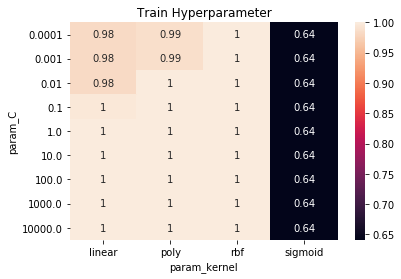

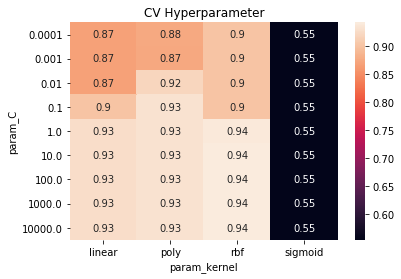

In [31]:
cv_pvt = pd.pivot_table(pd.DataFrame(svc_clf.cv_results_), values='mean_test_score', index='param_C', \
                     columns='param_kernel')
tr_pvt = pd.pivot_table(pd.DataFrame(svc_clf.cv_results_), values='mean_train_score', index='param_C', \
                     columns='param_kernel')

plt.title('Train Hyperparameter')
sns.heatmap(tr_pvt, annot=True)
plt.show()

plt.title('CV Hyperparameter')
sns.heatmap(cv_pvt, annot=True)
plt.show()

In [32]:
print(svc_clf.best_params_)
print('cv Score',svc_clf.score(cv_X,cv_y))

{'C': 10, 'kernel': 'rbf'}
cv Score 0.6458333333333334


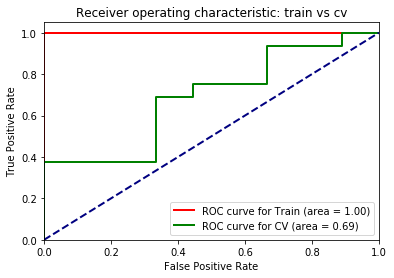

In [33]:
clf = CalibratedClassifierCV(svc_clf, cv=3)
clf.fit(tr_X,tr_y)

tr_pred = clf.predict_proba(tr_X)
cv_pred = clf.predict_proba(cv_X)

# Plot ROC curve of this model
plot_roc(tr_y, tr_pred, cv_y, cv_pred, 2)

## 5.3.1 Kaggle Score

In [34]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
svc_csv = clf.predict_proba(ts_X)[:,1]
svc_df = pd.DataFrame(np.column_stack((temp_id,svc_csv)), columns=['id','target'])
svc_df['id'] = svc_df['id'].astype('int32')
svc_df.to_csv(data_dir+'/submission_svc.csv', index=False)

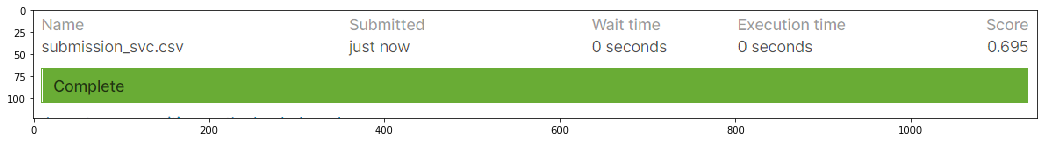

In [35]:
image = plt.imread(data_dir+'/submission_svc.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.4 RandomForest

In [11]:
# Impoer Random Forest
from sklearn.ensemble import RandomForestClassifier

In [37]:
# RandomForest (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

# List of hyperparameter that has t be tuned
params = {'n_estimators':[10,20,30,40,50,100,200,300,400],'max_depth':[2,3,5,7]}
# Instance of randomforest
rf_model = RandomForestClassifier(random_state=42)
# Perform GridSearchCV to find best parameters
rf_clf = hyperparameter_model(rf_model, params)

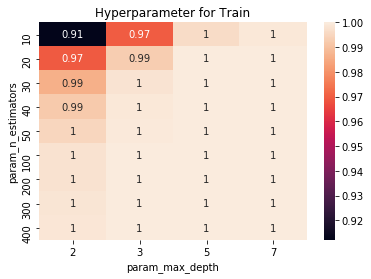

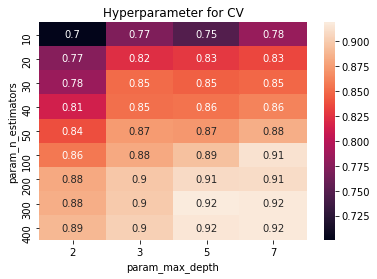

In [38]:
# Ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search

# Plotting of hyperpameter of train and cv score
pvt_tr = pd.pivot_table(pd.DataFrame(rf_clf.cv_results_), values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
pvt_cv = pd.pivot_table(pd.DataFrame(rf_clf.cv_results_), values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
plt.figure(1)
plt.title('Hyperparameter for Train')
sns.heatmap(pvt_tr, annot=True)
plt.figure(2)
plt.title('Hyperparameter for CV')
sns.heatmap(pvt_cv, annot=True)
plt.show()

In [39]:
print(rf_clf.best_params_)

{'max_depth': 5, 'n_estimators': 300}


In [40]:
# Calibrate the model
clf = CalibratedClassifierCV(rf_clf, cv=3)
clf.fit(tr_X, tr_y)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
                                                   error_score=nan,
                                                   estimator=RandomForestClassifier(bootstrap=True,
                                                                                    ccp_alpha=0.0,
                                                                                    class_weight=None,
                                                                                    criterion='gini',
                                                                                    max_depth=None,
                                                                                    max_features='auto',
                                                                                    max_leaf_nodes=None,
                                                                                    max_samples=None,


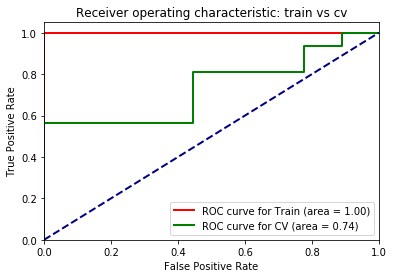

In [41]:
# Plot ROC Curve of train and cv
plot_roc(tr_y, clf.predict_proba(tr_X), cv_y, clf.predict_proba(cv_X), 2)

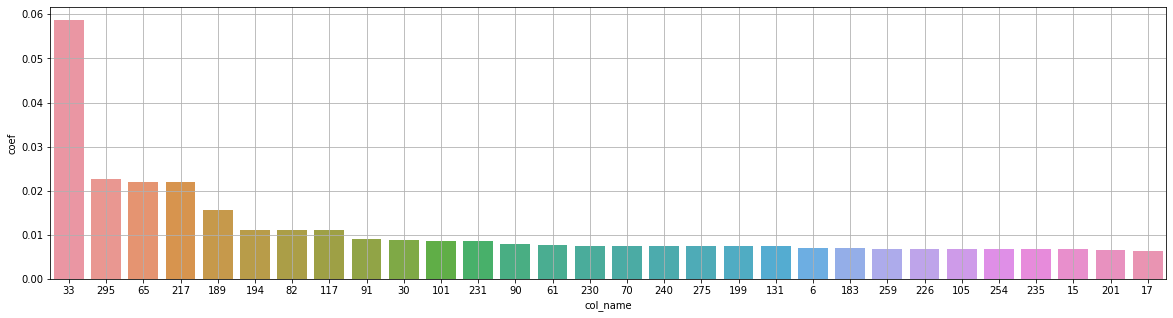

In [42]:
rf_clf = RandomForestClassifier(**rf_clf.best_params_, random_state=42)
rf_clf.fit(tr_X,tr_y)

# Plot the feature importance on the basis of this model
df = plot_feature_importance(rf_clf, 'rf',30)

## 5.4.1 Kaggle Score

In [43]:
temp_id = df_test['id']
rf_csv = clf.predict_proba(ts_X)[:,1]
rf_df = pd.DataFrame(np.column_stack((temp_id,rf_csv)), columns=['id','target'])
rf_df['id'] = rf_df['id'].astype('int32')
rf_df.to_csv(data_dir+'/submission_rf.csv', index=False)

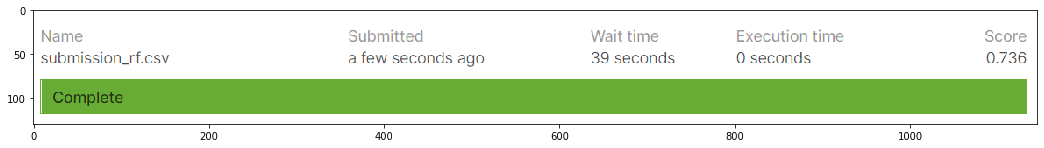

In [44]:
image = plt.imread(data_dir+'/submission_rf.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

## 5.5 Xgboost

In [12]:
# Import Xgboost
from xgboost import XGBClassifier

In [46]:
# Xgboost (See Docs: https://xgboost.readthedocs.io/en/latest/python/python_api.html)

# List of hyperparameter that has to be tuned
params = {'max_depth':[2,3,5,7], 'n_estimators':[10,20,50,100,200,300,400]}
# Instance of XGBoost Model
xgb_model = XGBClassifier(scale_pos_weight=0.5)
# Call hyperparameter to find the best parameters
xgb_clf = hyperparameter_model(xgb_model, params)

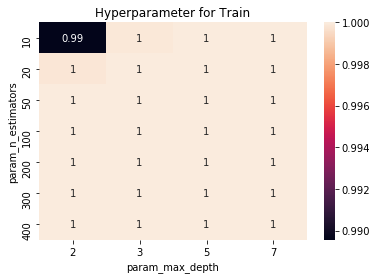

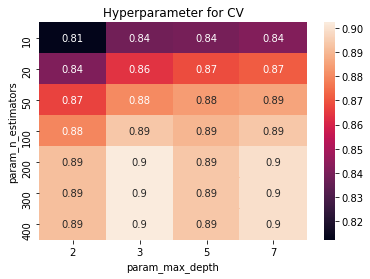

In [47]:
# Ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search

# Plotting of hyperpameter of train and cv score
pvt_tr = pd.pivot_table(pd.DataFrame(xgb_clf.cv_results_), values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
pvt_cv = pd.pivot_table(pd.DataFrame(xgb_clf.cv_results_), values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
plt.figure(1)
plt.title('Hyperparameter for Train')
sns.heatmap(pvt_tr, annot=True)
plt.figure(2)
plt.title('Hyperparameter for CV')
sns.heatmap(pvt_cv, annot=True)
plt.show()

In [48]:
print(xgb_clf.best_params_)
print('cv Score',xgb_clf.score(cv_X,cv_y))

{'max_depth': 3, 'n_estimators': 200}
cv Score 0.7847222222222223


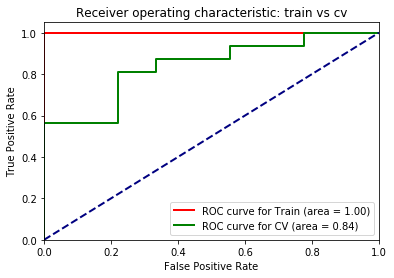

In [49]:
# Instance of randomforest with best parameters
xgb_clf = XGBClassifier(**xgb_clf.best_params_, random_state=42, scale_pos_weight=0.5)
# Fit the model
xgb_clf.fit(tr_X,tr_y)
# Calibrate the model
clf = CalibratedClassifierCV(xgb_clf, cv=3)
clf.fit(tr_X, tr_y)

tr_pred = clf.predict_proba(tr_X)
cv_pred = clf.predict_proba(cv_X)

# Plot ROC curve of train and cv
plot_roc(tr_y, tr_pred, cv_y, cv_pred, 2)

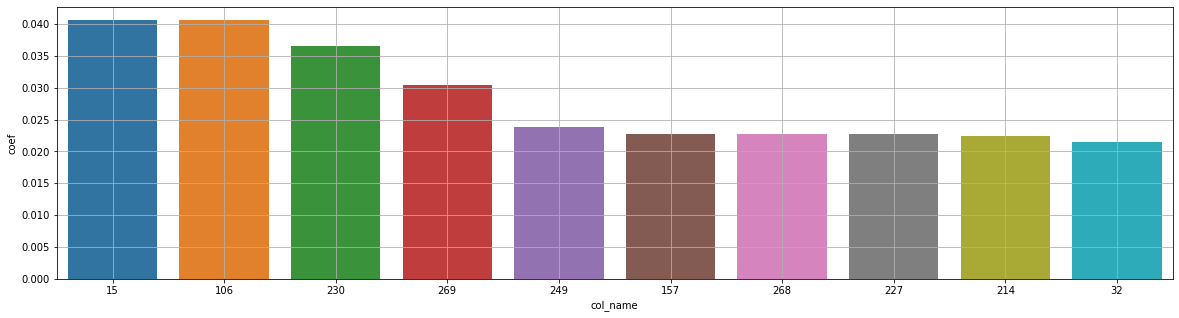

In [50]:
# Instance of XGBoost model with best parameters
df = plot_feature_importance(xgb_clf, 'xgb',10)

## 5.5.1 Kaggle Score

In [51]:
temp_id = df_test['id']
xgb_csv = clf.predict_proba(ts_X)[:,1]
xgb_df = pd.DataFrame(np.column_stack((temp_id,xgb_csv)), columns=['id','target'])
xgb_df['id'] = xgb_df['id'].astype('int32')
xgb_df.to_csv(data_dir+'/submission_xgb.csv', index=False)

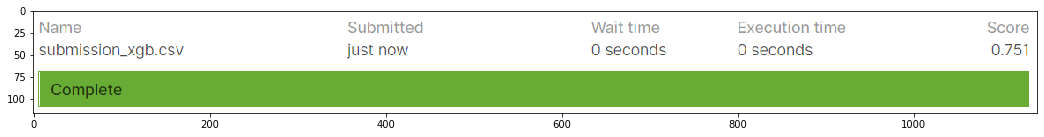

In [52]:
image = plt.imread(data_dir+'/submission_xgb.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

## 5.6 Stacking Model

In [13]:
# Import Stacking Classifier
from mlxtend.classifier import StackingClassifier

In [14]:
# StackClassifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#methods)

# Classifier 1: Logistic Regression with best params
clf1 = LogisticRegression(C = 1000, penalty = 'l1', solver = 'liblinear', class_weight='balanced', random_state=42)
clf1.fit(tr_X,tr_y)
clf1 = CalibratedClassifierCV(clf1, cv=3)

# Classifier 2: SVC with best params
clf2 = SVC(C=10, kernel='rbf', random_state=42, class_weight='balanced', probability=True)
clf2.fit(tr_X,tr_y)
clf2 = CalibratedClassifierCV(clf2, cv=3)

# Classifier 3: XGBoost with best params
clf3 = XGBClassifier(max_depth=3, n_estimators=200, scale_pos_weight=0.5)
clf3.fit(tr_X,tr_y)
clf3 = CalibratedClassifierCV(clf3, cv=3)

# Classifier 4: RF with best params
clf4 = RandomForestClassifier(max_depth=5, n_estimators=300)
clf4.fit(tr_X,tr_y)
clf4 = CalibratedClassifierCV(clf4, cv=3)

# Stack Classifier
sclf = StackingClassifier(classifiers=[clf1,clf2,clf3,clf4], meta_classifier=clf1, use_probas=True)

# Fit the model
sclf.fit(tr_X, tr_y)

# Predict in probabilities
tr_pred = sclf.predict_proba(tr_X)
cv_pred = sclf.predict_proba(cv_X)

In [55]:
# Score after stacking classifier
sclf.score(cv_X, cv_y)

0.68

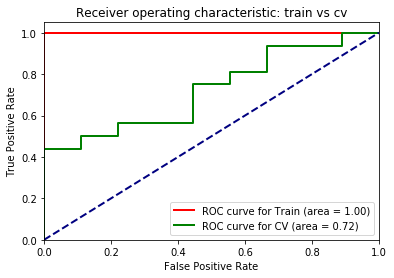

In [56]:
# Plot ROC Curve for train and cv
plot_roc(tr_y, tr_pred, cv_y, cv_pred,2)

## 5.6.1 Kaggle Score

In [57]:
temp_id = df_test['id']
sclf_csv = sclf.predict_proba(ts_X)[:,1]
sclf_df = pd.DataFrame(np.column_stack((temp_id,sclf_csv)), columns=['id','target'])
sclf_df['id'] = sclf_df['id'].astype('int32')
sclf_df.to_csv(data_dir+'/submission_sclf.csv', index=False)

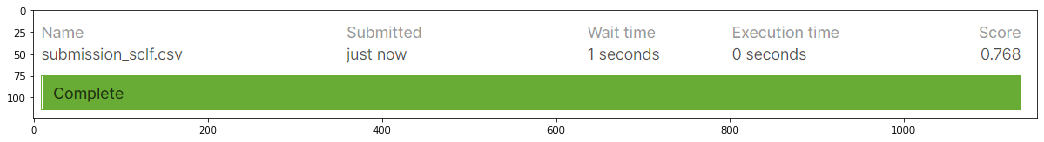

In [58]:
image = plt.imread(data_dir+'/submission_sclf.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.7 Voting Classifier (Without Stack Classifier + no weights)

In [15]:
# Import Voting Classifier
from mlxtend.classifier import EnsembleVoteClassifier

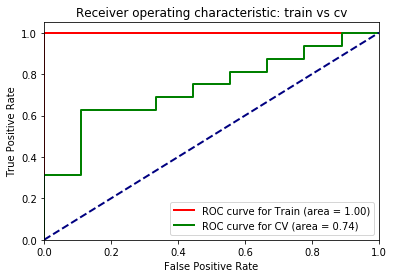

In [16]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2,clf3,clf4])
# Fit the train data
eclf.fit(tr_X,tr_y)

# Predict in probabilities
tr_pred = eclf.predict_proba(tr_X)
cv_pred = eclf.predict_proba(cv_X)
# Plot ROC Curve for train and cv
plot_roc(tr_y, tr_pred, cv_y, cv_pred,2)

# 5.7.1 Kaggle Score

In [17]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf.csv', index=False)

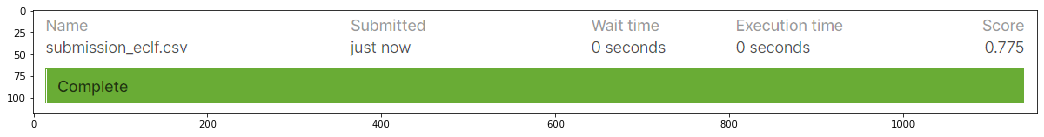

In [20]:
image = plt.imread(data_dir+'/submission_eclf.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.8 Voting Classifier (With Stack Classifier + no weights)

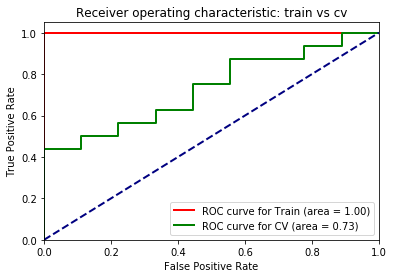

In [21]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2,clf3,clf4,sclf])
# Fit the train data
eclf.fit(tr_X,tr_y)

# Predict in probabilities
tr_pred = eclf.predict_proba(tr_X)
cv_pred = eclf.predict_proba(cv_X)
# Plot ROC Curve for train and cv
plot_roc(tr_y, tr_pred, cv_y, cv_pred,2)

# 5.8.1 Kaggle Score

In [19]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_stack.csv', index=False)

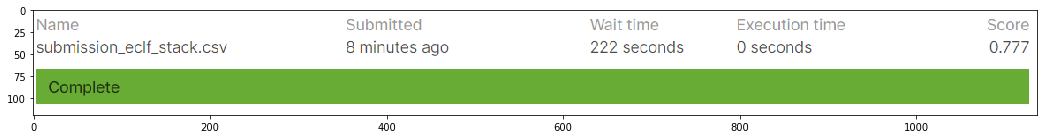

In [22]:
image = plt.imread(data_dir+'/submission_eclf_stack.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.9 Voting Classifier (without Stack Classifier + weights)

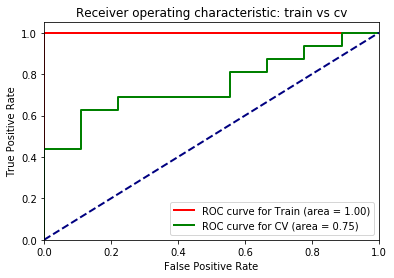

In [23]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1,clf2,clf3,clf4], weights=[0.3,0.1,0.3,0.3])
# Fit the train data
eclf.fit(tr_X,tr_y)

# Predict in probabilities
tr_pred = eclf.predict_proba(tr_X)
cv_pred = eclf.predict_proba(cv_X)
# Plot ROC Curve for train and cv
plot_roc(tr_y, tr_pred, cv_y, cv_pred,2)

# 5.9.1 Kaggle Score

In [24]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_weights.csv', index=False)

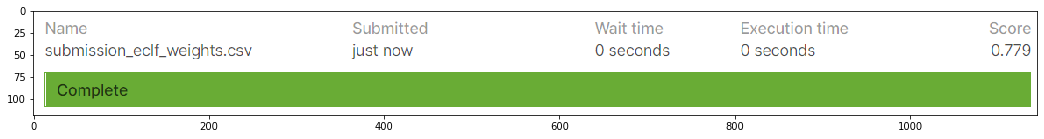

In [25]:
image = plt.imread(data_dir+'/submission_eclf_weights.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.10 Voting Classifier (with Stack Classifier + weights)

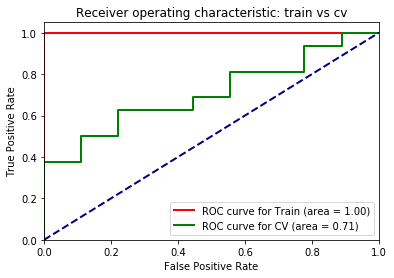

In [26]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1,clf2,clf3,clf4,sclf], weights=[0.3,0.05,0.15,0.2,0.3])
# Fit the train data
eclf.fit(tr_X,tr_y)

# Predict in probabilities
tr_pred = eclf.predict_proba(tr_X)
cv_pred = eclf.predict_proba(cv_X)
# Plot ROC Curve for train and cv
plot_roc(tr_y, tr_pred, cv_y, cv_pred,2)

# 5.10.1 Kaggle Score

In [27]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_stack_weights.csv', index=False)

In [ ]:
image = plt.imread(data_dir+'/submission_eclf_stack_weights.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 6. Summary of all Models

In [29]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = (['Model','Hyperparameter','CV score','Test score'])
x.add_row(['kNN',r"{'algorithm': 'kd_tree', 'n_neighbors': 47}",0.69,0.586])
x.add_row(['Logistic Regression',r"{'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}",0.65,0.772])
x.add_row(['SVC',r"{'C': 10, 'kernel': 'rbf'}",0.69,0.695])
x.add_row(['RandomForest',r"{'max_depth': 5, 'n_estimators': 300}",0.74,0.736])
x.add_row(['XGBoost',r"{'max_depth': 3, 'n_estimators': 200}",0.84,0.751])
x.add_row(['Stack Classifier','-',0.72,0.768])
x.add_row(['Voting Classifier(No stacking + no weights)','-',0.74,0.775])
x.add_row(['Voting Classifier(stacking + no weights)','-',0.73,0.777])
x.add_row(['Voting Classifier(no stacking + weights)','-',0.75,0.779])
x.add_row(['Voting Classifier(stacking + weights)','-',0.71,0.776])
print(x)

+---------------------------------------------+-----------------------------------------------------+----------+------------+
|                    Model                    |                    Hyperparameter                   | CV score | Test score |
+---------------------------------------------+-----------------------------------------------------+----------+------------+
|                     kNN                     |     {'algorithm': 'kd_tree', 'n_neighbors': 47}     |   0.69   |   0.586    |
|             Logistic Regression             | {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'} |   0.65   |   0.772    |
|                     SVC                     |              {'C': 10, 'kernel': 'rbf'}             |   0.69   |   0.695    |
|                 RandomForest                |        {'max_depth': 5, 'n_estimators': 300}        |   0.74   |   0.736    |
|                   XGBoost                   |        {'max_depth': 3, 'n_estimators': 200}        |   0.84   |   0.7